# 2D Variational MD

## Libraries

In [1]:
# Linear algebra libraries
import numpy as np
from numpy import linalg
from numpy import random
# Graphic libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
# Libraries to speed up code
import numba as numba
from numba import njit
# Optimization libraries
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint

plt.rcParams.update({'font.size': 16})

In [2]:
## Line to make plot in other windows of browser
%matplotlib

Using matplotlib backend: Qt5Agg


In [3]:
## Seed used for the simulation
np.random.seed(42)

## Functions

Useful functions used in the algorithm

In [4]:
@njit
def potential(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    U = u0*(np.exp(-(q[0]**2 + q[1]**2)) - 3.0/5.0*np.exp(-(q[0]**2 + (q[1] - b0)**2)) - np.exp(-((q[0]-x0)**2+q[1]**2)) - np.exp(-((q[0]+x0)**2 + q[1]**2))) + w0*(q[0]**4 + (q[1] - a0)**4)
    return U

@njit
def force(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    x2 = q[0]**2  # Square of x coordinate
    y2 = q[1]**2  # Square of y coordinate
    # Exponentials to speed up code
    e1 = np.exp(-(x2 + y2))
    e2 = np.exp(-(x2+(q[1]- b0)**2))
    e3 = np.exp(-((q[0] - x0)**2 + y2))
    e4 = np.exp(-((q[0] + x0)**2 + y2))
    # Components of the force
    fx = 2*u0*(q[0]*e1 -3.0/5.0*q[0]*e2 - (q[0]-x0)*e3 - (q[0]+x0)*e4)-4.0*w0*q[0]**3
    fy = 2*u0*(q[1]*e1 -3.0/5.0*(q[1] - b0)*e2 - q[1]*e3 - q[1]*e4)-4.0*w0*(q[1] - a0)**3
    return np.array([fx, fy])

@njit
def state(q, R=0.1): #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    state = 0  # Transition state
    tmp1 = q[0]**2 + 1.15**2 + q[1]**2
    tmp2 = 2.0*1.15*q[0]
    if tmp1 - tmp2 < R**2:
        # Product state
        state = 1
    if tmp1 + tmp2 < R**2:
        # Reactant state
        state = -1
    return state

Committor guesses.

Linear committor

In [5]:
#First guess of the committor function: q increases linearly along x
@njit
def qLin(q, R=0.2):
    if q[0] <= R-1.15:
        return 0
    elif q[0] >= 1.15-R:
        return 1
    else:
        return q[0]/(2.0*(1.15-R))+0.5

#Gradient of the first committor guess
@njit
def dqLin(q, R=0.2):
    if q[0] < R-1.15 or q[0] > 1.15-R:
        return 0.0, 0.0
    else:
        return 1.0/(2.0*(1.15-R)), 0.0

    
#Alternative first guess of the committor function: q increases linearly along x
@njit
def qLin2(q, R=0.2):  
    if q[0] <= -R-1.15:
        return 0
    elif q[0] >= 1.15+R:
        return 1
    elif (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 1
    else:
        return q[0]/(2.0*(1.15+R))+0.5

#Gradient of the first committor guess
@njit
def dqLin2(q, R=0.2):
    if q[0] < -R-1.15 or q[0] > 1.15+R or (q[0] - 1.15)**2 + q[1]**2 <= R**2 or (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    else:
        return 1.0/(2.0*(1.15+R)), 0.0
    
    
#Second alternative first guess of the committor function: q increases linearly along x
@njit
def qLin3(q, R=0.2):
    if q[0] <= -1.15:
        return 0
    elif q[0] >= 1.15:
        return 1
    elif (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 1
    else:
        return q[0]/(2.0*1.15)+0.5

#Gradient of the first committor guess
@njit
def dqLin3(q, R=0.2):
    if q[0] < -1.15 or q[0] > 1.15 or (q[0] - 1.15)**2 + q[1]**2 <= R**2 or (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    else:
        return 1.0/(2.0*1.15), 0.0    

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qLin'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-372843fce024>", line 3:
@njit
def qLin(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


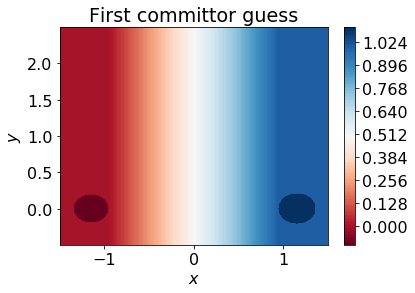

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqLin'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-372843fce024>", line 13:
@njit
def dqLin(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


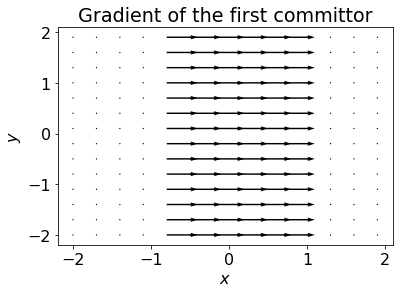

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qLin2'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-372843fce024>", line 22:
@njit
def qLin2(q, R=0.2):  
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


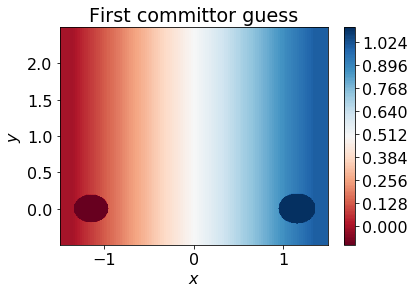

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqLin2'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-372843fce024>", line 36:
@njit
def dqLin2(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


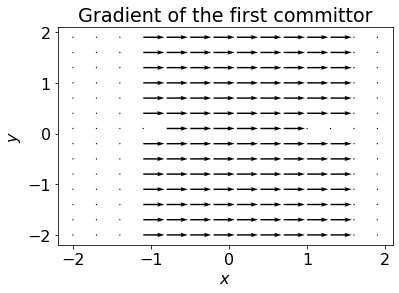

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qLin3'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-372843fce024>", line 45:
@njit
def qLin3(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


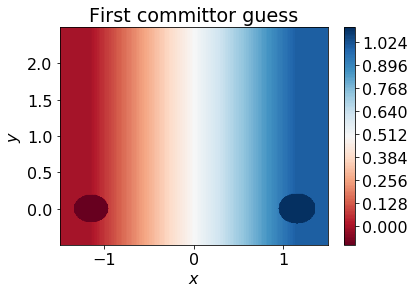

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqLin3'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-372843fce024>", line 59:
@njit
def dqLin3(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


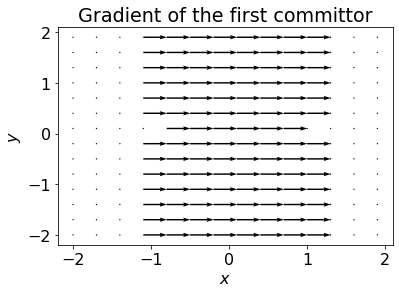

In [6]:
R = 0.2

## Colour plot of the first committor guess
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qLin([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('First committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

## Gradient of the first committor
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))

Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqLin([x[i,j], y[i,j]], R=R)
        
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
plt.title("Gradient of the first committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()    

## Colour plot of the first committor guess
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qLin2([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('First committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

## Gradient of the first committor
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))

Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqLin2([x[i,j], y[i,j]], R=R)
        
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
plt.title("Gradient of the first committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()    

## Colour plot of the first committor guess
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qLin3([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('First committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

## Gradient of the first committor
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))

Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqLin3([x[i,j], y[i,j]], R=R)
        
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
plt.title("Gradient of the first committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()  

Circular committor

In [6]:
#Second guess of the committor function: q increases along a circle
@njit
def qCircle(q, R=0.2):
    if q[0] == 0 and q[1] == 0:
        return 0.5
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0
    elif theta > np.pi - alpha:
        return 1.0
    else: 
        return (theta - alpha)/(np.pi - alpha)

#Gradient of the second committor guess
@njit
def dqCircle(q, R=0.2):
    if q[0] == 0.0 and q[1] == 0.0:
        return 0.0, 0.0
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0, 0.0
    elif theta > np.pi - alpha:
        return 0.0, 0.0
    else: 
        if q[1]>0:
            return q[1]/(q[0]**2 + q[1]**2), -q[0]/(q[0]**2 + q[1]**2)
        else:
            return -q[1]/(q[0]**2 + q[1]**2), q[0]/(q[0]**2 + q[1]**2)
        
        
#Second guess of the committor function: q increases along a circle
@njit
def qCircleU(q, R=0.2):
    if q[0] == 0 and q[1] == 0:
        return 0.5
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0
    elif theta > np.pi - alpha:
        return 1.0
    else:
        if q[1] < 0.0:
            return 0.0
        else:
            return (theta - alpha)/(np.pi - alpha)


#Gradient of the second committor guess
@njit
def dqCircleU(q, R=0.2):
    if q[0] == 0.0 and q[1] == 0.0:
        return 0.0, 0.0
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0, 0.0
    elif theta > np.pi - alpha:
        return 0.0, 0.0
    else: 
        if q[1] > 0.0:
            return q[1]/(q[0]**2 + q[1]**2), -q[0]/(q[0]**2 + q[1]**2)
        else:
            return 0.0, 0.0            
                
#Second guess of the committor function: q increases along a circle
@njit
def qCircleD(q, R=0.2):
    if q[0] == 0 and q[1] == 0:
        return 0.5
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0
    elif theta > np.pi - alpha:
        return 1.0
    else:
        if q[1] > 0.0:
            return 0.0
        else:
            return (theta - alpha)/(np.pi - alpha)   
        
#Gradient of the second committor guess
@njit
def dqCircleD(q, R=0.2):
    if q[0] == 0.0 and q[1] == 0.0:
        return 0.0, 0.0
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0, 0.0
    elif theta > np.pi - alpha:
        return 0.0, 0.0
    else: 
        if q[1]< 0.0:
            return -q[1]/(q[0]**2 + q[1]**2), q[0]/(q[0]**2 + q[1]**2)
        else:
            return 0.0, 0.0

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qCircle'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-3a5266788de3>", line 3:
@njit
def qCircle(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


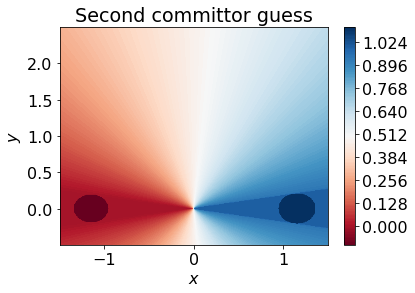

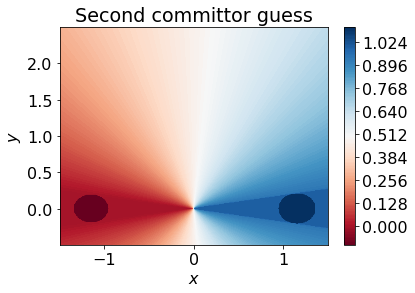

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqCircle'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-3a5266788de3>", line 17:
@njit
def dqCircle(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


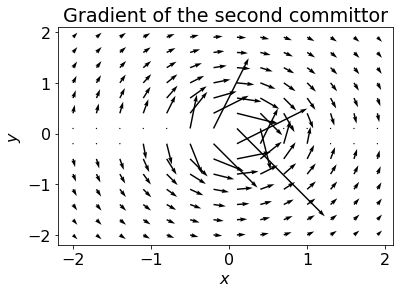

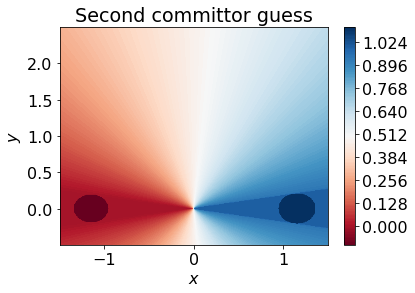

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qCircleU'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-3a5266788de3>", line 35:
@njit
def qCircleU(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


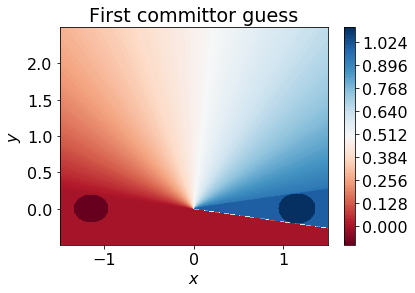

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqCircleU'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-3a5266788de3>", line 53:
@njit
def dqCircleU(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


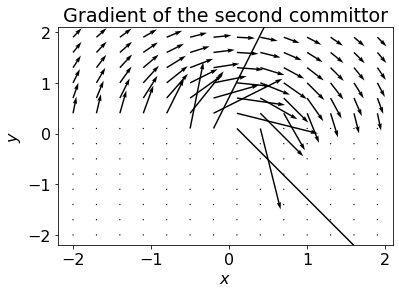

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qCircleD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-3a5266788de3>", line 70:
@njit
def qCircleD(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


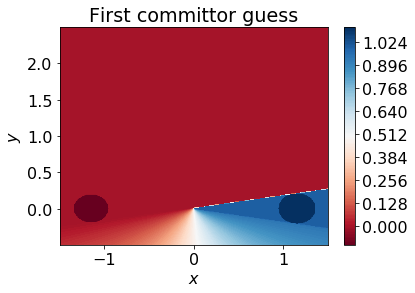

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqCircleD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-3a5266788de3>", line 87:
@njit
def dqCircleD(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


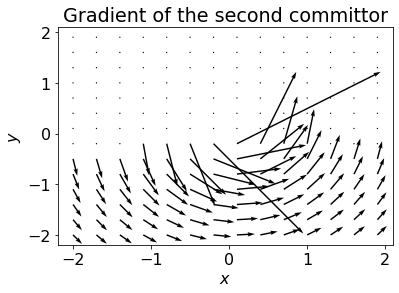

In [8]:
R=0.2

## Second committor guess function
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qCircle([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('Second committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

## Second committor guess function
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qCircle([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('Second committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


## Gradient of the second committor
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))

Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqCircle([x[i,j], y[i,j]], R=R)
        
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
plt.title("Gradient of the second committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()     

## Second committor guess function
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qCircle([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('Second committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()




## Second committor guess function - only up half-plane
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qCircleU([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('First committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


## Gradient of the second committor
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))

Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqCircleU([x[i,j], y[i,j]], R=R)
        
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
plt.title("Gradient of the second committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show() 


## Second committor guess function - only down half-plane
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qCircleD([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('First committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


## Gradient of the second committor
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))

Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqCircleD([x[i,j], y[i,j]], R=R)
        
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
plt.title("Gradient of the second committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show() 

Distance committor

In [7]:
# Third guess function: euclidian distance between the two states
@njit
def qDist(q, R=0.2):
    if (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 1.0
    elif (q[0] - 1.15)**2 + q[1]**2 >= (2.0*1.15-R)**2:
        return 0.0
    else:
        return 1.0-(np.sqrt((q[0] - 1.15)**2 + q[1]**2)-R)/(2.0*(1.15-R))
        
@njit        
def dqDist(q, R=0.2):
    if (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 >= (2.0*1.15+R)**2:
        return 0.0, 0.0
    else:
        return -(q[0] - 1.15)/(2.0*(1.15-R)*np.sqrt((q[0] - 1.15)**2 + q[1]**2)), -q[1]/(2.0*(1.15-R)*np.sqrt((q[0] - 1.15)**2 + q[1]**2))


# Third guess function: euclidian distance between the two states
@njit
def qDist2(q, R=0.2):
    if (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 1.0
    elif (q[0] - 1.15)**2 + q[1]**2 >= (2.0*1.15+R)**2:
        return 0.0
    else:
        return 1.0-(np.sqrt((q[0] - 1.15)**2 + q[1]**2)-R)/(2.0*1.15)
        
@njit        
def dqDist2(q, R=0.2):
    if (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 >= (2.0*1.15+R)**2:
        return 0.0, 0.0
    else:
        return -(q[0] - 1.15)/(2.0*1.15*np.sqrt((q[0] - 1.15)**2 + q[1]**2)), -q[1]/(2.0*1.15*np.sqrt((q[0] - 1.15)**2 + q[1]**2))

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qDist'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-322b17a85972>", line 3:
@njit
def qDist(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


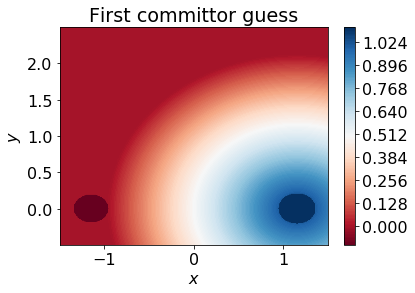

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqDist'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-322b17a85972>", line 14:
@njit        
def dqDist(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


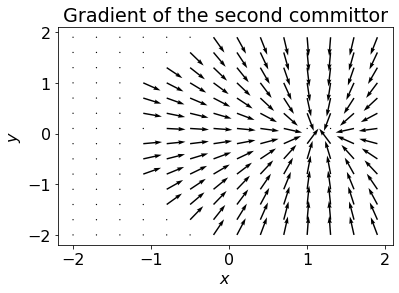

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qDist2'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-322b17a85972>", line 27:
@njit
def qDist2(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


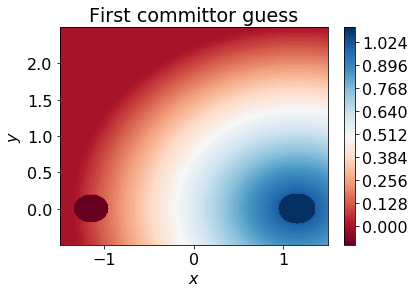

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqDist2'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-322b17a85972>", line 38:
@njit        
def dqDist2(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


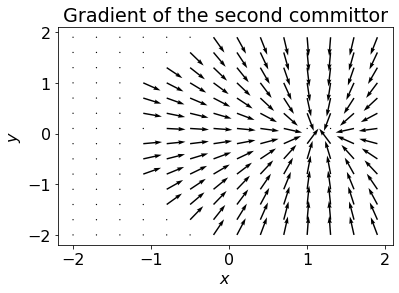

In [10]:
R=0.2

## Third committor guess function
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qDist([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('First committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


## Gradient of the second committor
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))

Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqDist([x[i,j], y[i,j]], R=R)
        
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
plt.title("Gradient of the second committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show() 


## Third committor guess function
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qDist2([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('First committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


## Gradient of the second committor
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))

Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqDist2([x[i,j], y[i,j]], R=R)
        
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
plt.title("Gradient of the second committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show() 

In [8]:
def comm_plot(Guess1, Guess2, c = [0.5, 0.5], R = 0.2):
    ## Colour plot of the first committor guess
    # make these smaller to increase the resolution
    dx, dy = 0.01, 0.01
    
    # generate 2 2d grids for the x & y bounds
    y, x = np.mgrid[slice(-1.5, 1.5 + dy, dy),
                    slice(-1.5, 1.5 + dx, dx)]

    G = np.copy(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
                G[i,j] = 1.1
            elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
                G[i,j] = -0.1
            else:
                G[i,j] = c[0]*Guess1([x[i,j], y[i,j]], R=R) + c[1]*Guess2([x[i,j], y[i,j]], R=R)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    G = G[:-1, :-1]
    levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


    # pick the desired colormap, sensible levels, and define a normalization
    # instance which takes data values and translates those into levels.
    cmap = plt.get_cmap('RdBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    fig, ax = plt.subplots()

    # contours are *point* based plots, so convert our bound into point
    # centers
    cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
    fig.colorbar(cf, ax=ax)
    ax.set_title('Committor')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    plt.show()

## Integrator

In [9]:
@njit
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, q0 = None,c = [0.5,0.5], R =0.2, dt = 0.02, KbT = 0.15, kr = 250, isteps = 4000):
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    M = np.empty((isteps,2,2), dtype=np.float64)
    # Assign initial position to the border of the reactant state
    if q0 is None:
        r = random.random_sample()
        q[0,0] = -1.15+R*r+0.001
        q[0,1] = R*np.sqrt(1.0-r**2)+0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:], R) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    #print('zmax= ', zmax)
    #print('State:= ', s)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        ## Evaluate evolution of the system
        f = force(q[i,:])
        # Linear combination of committors
        z0 = Guess1(q[i,:], R)
        z1 = Guess2(q[i,:], R)
        z = c[0]*z0+c[1]*z1
        # Gradient components of the committors
        dGx1, dGy1 = dGuess1(q[i,:], R)
        dGx2, dGy2 = dGuess2(q[i,:], R)
        # Matrix M
        M[i,0,0] = dGx1**2 + dGy1**2
        M[i,1,0] = dGx2*dGx1+dGy2*dGy1
        M[i,0,1] = dGx1*dGx2+dGy1*dGy2
        M[i,1,1] = dGx2**2 + dGy2**2
        #print(z0, z1, z[i])
        if z > zmax:
            q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
            zmax = z
        else:
            q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)+kr*(c[0]*dGx1 + c[1]*dGx2)*(zmax - z)*dt
            q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)+kr*(c[0]*dGy1 + c[1]*dGy2)*(zmax - z)*dt
        i += 1
        s = state(q[i,:], R)
        #print('State:= ', s)
        #print('Position:= ',q[i,:])
        #print('Trajectory length:= ', i-j-2)
        
    M *= np.sqrt(2.0*KbT)
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        outM = np.empty((1, 2, 2), dtype=np.float64)
        outM[0,0,0] = 0.0
        outM[0,1,0] = 0.0
        outM[0,0,1] = 0.0
        outM[0,1,1] = 0.0
        return out, outM
        
    return q[j+1:i-1,:], M[j+1:i-1,:,:]

In [30]:
# Figure
plt.figure()
tmp = 0
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qCircleU, dGuess1 = dqCircleU, Guess2 = qDist, dGuess2 = dqDist, kr = 150, c = [0.5, 0.5])
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)

plt.title('Trajectories with circular/distance committor')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


# Density plot of how much time the system passes in a given point
xedges = np.arange(-1.5, 1.5, 0.02).tolist()
yedges = np.arange(-1.5, 2.0, 0.02).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Probability density with circular/distance committor")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

Now we average the values of M

In [ ]:
M = np.zeros((2,2), dtype=np.float64)
# Average all the values of M
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

In [ ]:
# Compute the new coefficients c  
cout = np.zeros(2)
cout[0]=M[1,1] - M[0,1]
cout[1]=M[0,0] - M[1,0]
cout /= np.sum(cout)

print("c= ",cout)

comm_plot(Guess1 = qLin2, Guess2 = qCircleU, c = cout)

In [10]:
@njit
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

In [ ]:
res = minimize(I, [1.0, 1.0],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

Iterative procedure

In [12]:
def Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c, R = 0.2, dt = 0.02, KbT = 0.15, kr = 250, isteps = 4000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M = LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = c, R = R, dt = dt, KbT = KbT, kr = kr, isteps= isteps)
        if traj[0,0] != 0 and traj[0,1] != 0:
            if tmp==0:
                trajall = np.copy(traj)
                Mall = np.copy(M)
                tmp = 1
            if tmp==1:
                trajall = np.concatenate((trajall, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
        del traj, M
    
    # Evaluation of M
    M = np.zeros((2,2), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    
    # Compute the new coefficients c  
    #cout = np.zeros(2)
    #cout[0]=M[1,1] - M[0,1]
    #cout[1]=M[0,0] - M[1,0]
    #cout /= np.sum(cout)
    
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=LinearConstraint([1.0, 1.0], 1.0, 1.0),
               options={'verbose': 0}, bounds=Bounds([0.0, 0.0], [1.0, 1.0]))
    
    
    return cout.x

In [ ]:
c = Boltz_sample(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qCircleU, dGuess2 = dqCircleU, kr=100, c = [0.5, 0.5])
print(c)

In [13]:
def Self_consistent(Guess1, dGuess1, Guess2, dGuess2, c = [0.5, 0.5], R = 0.2, dt = 0.02, KbT = 0.15, kr = 250, isteps = 4000, jsteps = 1000, ksteps = 100, alpha = 0.8):       
    cout = np.empty((ksteps, 2), dtype=np.float64)
    cout[0,0] = c[0]
    cout[0,1] = c[1]
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = c, R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = alpha*cout[k+1,:] + (1.0 - alpha)*cout[k,:], R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

In [22]:
c = Self_consistent(Guess1 = qCircleU, dGuess1 = dqCircleU, Guess2 = qDist, dGuess2 = dqDist, kr = 150, c = [0.5, 0.5], ksteps=30,alpha = 0.5)

plt.figure()
plt.plot(c[:,0], label = r"$c_0$")
plt.plot(c[:,1], label = r"$c_1$")
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()


plt.figure()
plt.plot(c[:,0]+c[:,1] - 1.0)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()


print(c[-1,:])
comm_plot(Guess1 = qCircleU, Guess2 = qDist, c = c[-1,:])

Cycle =  1
Cycle =  2


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-fce6d98e94f0>", line 2:
@njit
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, q0 = None,c = [0.5,0.5], R =0.2, dt = 0.02, KbT = 0.15, kr = 250, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Cycle =  3
Cycle =  4
Cycle =  5
Cycle =  6
Cycle =  7
Cycle =  8
Cycle =  9
Cycle =  10
Cycle =  11
Cycle =  12
Cycle =  13
Cycle =  14
Cycle =  15
Cycle =  16
Cycle =  17
Cycle =  18
Cycle =  19
Cycle =  20
Cycle =  21
Cycle =  22
Cycle =  23
Cycle =  24
Cycle =  25
Cycle =  26
Cycle =  27
Cycle =  28
Cycle =  29
Cycle =  30
[0.91959604 0.08040396]


In [21]:
# Figure
plt.figure()
tmp = 0
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qCircleU, dGuess1 = dqCircleU, Guess2 = qDist, dGuess2 = dqDist, kr = 150, c = c[-1,:])
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)

plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


# Density plot of how much time the system passes in a given point
xedges = np.arange(-1.5, 1.5, 0.02).tolist()
yedges = np.arange(-1.5, 2.0, 0.02).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Sampling transition region")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

## Second proposal: squared coefficients

In [23]:
def comm_plot2(Guess1, Guess2, c = [np.sqrt(0.5), np.sqrt(0.5)], R = 0.2):
    ## Colour plot of the first committor guess
    # make these smaller to increase the resolution
    dx, dy = 0.01, 0.01
    
    # generate 2 2d grids for the x & y bounds
    y, x = np.mgrid[slice(-1.5, 1.5 + dy, dy),
                    slice(-1.5, 1.5 + dx, dx)]

    G = np.copy(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
                G[i,j] = 1.1
            elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
                G[i,j] = -0.1
            else:
                G[i,j] = c[0]**2*Guess1([x[i,j], y[i,j]], R=R) + c[1]**2*Guess2([x[i,j], y[i,j]], R=R)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    G = G[:-1, :-1]
    levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


    # pick the desired colormap, sensible levels, and define a normalization
    # instance which takes data values and translates those into levels.
    cmap = plt.get_cmap('RdBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    fig, ax = plt.subplots()

    # contours are *point* based plots, so convert our bound into point
    # centers
    cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
    fig.colorbar(cf, ax=ax)
    ax.set_title('Committor')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    plt.show()

In [24]:
@njit
def LI_RMD2(Guess1, dGuess1, Guess2, dGuess2, q0 = None, c = [np.sqrt(0.5), np.sqrt(0.5)], R =0.2, dt = 0.02, KbT = 0.15, kr = 250, isteps = 4000):
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    M = np.empty((isteps,2,2), dtype=np.float64)
    # Assign initial position to the border of the reactant state
    r = random.random_sample()
    # I just precompute the square of the coefficients to speed up the code
    c02 = c[0]**2
    c12 = c[1]**2
    if q0 is None:
        r = random.random_sample()
        q[0,0] = -1.15+R*r+0.001
        q[0,1] = R*np.sqrt(1.0-r**2)+0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:], R) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    z0 = Guess1(q[0,:], R)
    z1 = Guess2(q[0,:], R)
    zmax = c02*z0+c12*z1
    #print('zmax= ', zmax)
    #print('State:= ', s)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        ## Evaluate evolution of the system
        f = force(q[i,:])
        # Linear combination of committors
        z0 = Guess1(q[i,:], R)
        z1 = Guess2(q[i,:], R)
        z = c02*z0+c12*z1
        # Gradient components of the committors
        dGx1, dGy1 = dGuess1(q[i,:], R)
        dGx2, dGy2 = dGuess2(q[i,:], R)
        # Matrix M
        M[i,0,0] = dGx1**2 + dGy1**2
        M[i,1,0] = dGx2*dGx1+dGy2*dGy1
        M[i,0,1] = dGx1*dGx2+dGy1*dGy2
        M[i,1,1] = dGx2**2 + dGy2**2
        #print(z0, z1, z[i])
        if z > zmax:
            q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
            zmax = z
        else:
            q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)+kr*(c02*dGx1 + c12*dGx2)*(zmax - z)*dt
            q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)+kr*(c02*dGy1 + c12*dGy2)*(zmax - z)*dt
        i += 1
        s = state(q[i,:], R)
        #print('State:= ', s)
        #print('Position:= ',q[i,:])
        #print('Trajectory length:= ', i-j-2)
        
    M *= np.sqrt(2.0*KbT)
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        outM = np.empty((1, 2, 2), dtype=np.float64)
        outM[0,0,0] = 0.0
        outM[0,1,0] = 0.0
        outM[0,0,1] = 0.0
        outM[0,1,1] = 0.0
        return out, outM
        
    return q[j+1:i-1,:], M[j+1:i-1,:,:]

In [ ]:
# Figure
plt.figure()
tmp = 0
for i in range(1000):
    traj, M = LI_RMD2(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qCircleD, dGuess2 = dqCircleD, c = [np.sqrt(0.5), np.sqrt(0.5)])
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)

plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


# Density plot of how much time the system passes in a given point
xedges = np.arange(-1.5, 1.5, 0.02).tolist()
yedges = np.arange(-1.5, 2.0, 0.02).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Sampling transition region")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

In [ ]:
M = np.zeros((2,2), dtype=np.float64)
# Average all the values of M
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

In [25]:
@njit
def I2(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[i]*c[j]*c[j]
    return Iout

@njit
def I2_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]*c[j]
        Iout[i] *= 4.0*c[i]
    return Iout

@njit
def I2_hess(c,M):
    Iout = np.zeros_like(M)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i,j] = 8.0*M[i,j]*c[i]*c[j]
            if i == j:
                for k in range(len(c)):
                    Iout[i,j] += 4.0*M[i,k]*c[k]*c[k]
    return Iout

In [26]:
def cons_f(x):
    return [x[0]**2 + x[1]**2]

def cons_J(x):
    return [2*x[0], 2*x[1]]

def cons_H(x, v):
    return v[0]*np.array([2, 2])

In [27]:
nonlinear_constraint = NonlinearConstraint(cons_f, 1, 1, jac=cons_J, hess=cons_H)

In [ ]:
res = minimize(I2, [1.0, 1.0],M, method='trust-constr', jac=I2_der, hess=I2_hess,
               constraints=nonlinear_constraint,
               options={'verbose': 1})

print(res.x)

Iterative procedure

In [28]:
def Boltz_sample2(Guess1, dGuess1, Guess2, dGuess2, c, R = 0.2, dt = 0.02, KbT = 0.15, kr = 250, isteps = 4000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M = LI_RMD2(Guess1, dGuess1, Guess2, dGuess2, c = c, R = R, dt = dt, KbT = KbT, kr = kr, isteps= isteps)
        if traj[0,0] != 0 and traj[0,1] != 0:
            if tmp==0:
                trajall = np.copy(traj)
                Mall = np.copy(M)
                tmp = 1
            if tmp==1:
                trajall = np.concatenate((trajall, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
        del traj, M
    
    # Evaluation of M
    M = np.zeros((2,2), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    
    # Compute the new coefficients c  
    #cout = np.zeros(2)
    #cout[0]=M[1,1] - M[0,1]
    #cout[1]=M[0,0] - M[1,0]
    #cout /= np.sum(cout)
    cout = minimize(I2, [1.0, 1.0],M, method='trust-constr', jac=I2_der, hess=I2_hess,
               constraints=nonlinear_constraint,
               options={'verbose': 0})
    
    return cout.x

In [ ]:
c = Boltz_sample2(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qCircleU, dGuess2 = dqCircleU, kr=100, c = [np.sqrt(0.5), np.sqrt(0.5)])
print(c)

In [29]:
def Self_consistent2(Guess1, dGuess1, Guess2, dGuess2, c = [np.sqrt(0.5), np.sqrt(0.5)], R = 0.2, dt = 0.02, KbT = 0.15, kr = 250, isteps = 4000, jsteps = 1000, ksteps = 100, alpha = 0.8):       
    cout = np.empty((ksteps, 2), dtype=np.float64)
    cout[0,0] = c[0]
    cout[0,1] = c[1]
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sample2(Guess1, dGuess1, Guess2, dGuess2, c = c, R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sample2(Guess1, dGuess1, Guess2, dGuess2, c = np.sqrt(alpha*cout[k+1,:]**2 + (1.0 - alpha)*cout[k,:]**2), R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

In [30]:
c = Self_consistent2(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qCircleU, dGuess2 = dqCircleU, kr = 150, c = [np.sqrt(0.5), np.sqrt(0.5)], ksteps=30,alpha = 0.5)

plt.figure()
plt.plot(c[:,0]**2, label = r"$c_0$")
plt.plot(c[:,1]**2, label = r"$c_1$")
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

constraint = np.zeros_like(c[:,0])
for i in range(len(c[:,0])):
    constraint[i] = c[i,0]**2+c[i,1]**2-1.0
plt.figure()
plt.plot(constraint)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

print(c[-1,:])
comm_plot2(Guess1 = qLin, Guess2 = qCircleU, c = c[-1,:])

Cycle =  1
Cycle =  2


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD2'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-24-fbb2fbd91c39>", line 2:
@njit
def LI_RMD2(Guess1, dGuess1, Guess2, dGuess2, q0 = None, c = [np.sqrt(0.5), np.sqrt(0.5)], R =0.2, dt = 0.02, KbT = 0.15, kr = 250, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Cycle =  3
Cycle =  4
Cycle =  5
Cycle =  6
Cycle =  7
Cycle =  8
Cycle =  9
Cycle =  10
Cycle =  11
Cycle =  12
Cycle =  13
Cycle =  14
Cycle =  15
Cycle =  16
Cycle =  17
Cycle =  18
Cycle =  19
Cycle =  20
Cycle =  21
Cycle =  22
Cycle =  23
Cycle =  24
Cycle =  25
Cycle =  26
Cycle =  27
Cycle =  28
Cycle =  29
Cycle =  30
[0.98940186 0.14520319]


In [ ]:
# Figure
plt.figure()
tmp = 0
for i in range(1000):
    traj, M = LI_RMD2(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qCircle, dGuess2 = dqCircle, kr = 100, c = c[-1,:])
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)

plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


# Density plot of how much time the system passes in a given point
xedges = np.arange(-1.5, 1.5, 0.02).tolist()
yedges = np.arange(-1.5, 2.0, 0.02).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Sampling transition region")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()